### Gaussian Sequential Simulationa and Processes

In [1]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import cholesky, cho_solve
from scipy.optimize import curve_fit, minimize
from sklearn.gaussian_process import GaussianProcessRegressor

# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [2]:
# INPUT DATA (SIMPLE EXAMPLE)

# Sample points for prediction
X = np.linspace(-10, 10, 100).reshape(-1, 1)  # 100 points from -5 to 5

# Observed data points
X_train = np.linspace(-10, 10, 11).reshape(-1, 1)  # 10 training points
#y_train = np.sin(X_train).flatten()  # Example function values at training points
y_train = -np.square(X_train).flatten()  # Example function values at training points

y_train[1] = -100
y_train[2] = -80
y_train[3] = -50
y_train[7] = -40
y_train[8] = -90
y_train[9] = -100

y_train = y_train * 10

# Sample points for prediction
X = np.linspace(-1000, 1000, 100).reshape(-1, 1)  # 100 points from -5 to 5
# Observed data points
X_train = np.linspace(-1000, 1000, 11).reshape(-1, 1)  # 10 training points

In [3]:
# KERNELS

# RBF kernel function
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = np.sum((x1 - x2)**2)
    #dists = cdist(x1, x2, 'euclidean')**2
    return variance * np.exp(-0.5 * sqdist / length_scale**2)
    #return variance * np.exp(-0.5 * dists / length_scale**2)

# Matern kernel function
def matern_kernel(x1, x2, length_scale, nu, variance):
    
    # Calculate the Euclidean distance between points
    #d = np.sqrt(np.sum((x1 - x2)**2, axis=-1))
    d = np.linalg.norm(np.array(x1) - np.array(x2))
    #d = cdist(x1, x2, 'euclidean')
    
    # Special case where nu is large (approximates RBF kernel)
    if nu == np.inf:
        return variance * np.exp(-0.5 * (d / length_scale)**2)
    
    # Compute the Matern kernel
    scaling_factor = 2**(1.0 - nu) / gamma(nu)
    distance_term = np.sqrt(2 * nu) * d / length_scale
    matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
        
    # Handle the case when distance is zero to avoid NaNs
    matern_value = np.where(d == 0.0, 1, matern_value)
    #matern_value = np.nan_to_num(matern_value, variance)
    
    return variance * matern_value

# Variogram model (spherical)
def variogram(h, range_a, sill, nugget):
    """ Spherical variogram model """
    h = np.abs(h)
    return np.where(h < range_a,
                    nugget + sill * (1.5 * (h / range_a) - 0.5 * (h / range_a)**3),
                    nugget + sill)

In [4]:
# PARAMETERS FOR COVARIANCE MATRIX AND VARIOGRAM

# Noise
noise = 10

# Covariance matrix parameters
length_scale = 500
variance = 500
varaiance_for_title = variance
nu = 1.5 # 1/2 becomes exponential covariance function k(r) = exp(-r/l)
         # 3/2 and 5/2 for ML
         # Carl Edward Rasmussen and Christopher K. I. Williams,
         # Gaussian Processes for Machine Learning,
         # Adaptive Computation and Machine Learning (Cambridge, Mass: MIT Press, 2006), p85.

# Variogram parameters
range_a = length_scale  # Range of the variogram, assumed equal to length scale of covariance matrix kernel
sill = variance  # Sill of the variogram, , assumed equal to variance of covariance matrix kernel
nugget = noise # Nugget effect

In [5]:
# WHITE NOISE GENERATION

WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

WhiteKernel(noise_level=1)

In [6]:
# GAUSSIAN PROCESS EXAMPLE 

# Covariance matrix for the training points
K = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        K[i, j] = matern_kernel(X_train[i], X_train[j], length_scale, nu, variance)

# Add noise to diagonal of covariance matrix
K = K + np.random.normal(0, noise, len(X_train)) * np.eye(len(X_train))

# Covariance matrix between the training points and the test points
K_s = np.zeros((len(X_train), len(X)))
for i in range(len(X_train)):
    for j in range(len(X)):
        K_s[i, j] = matern_kernel(X_train[i], X[j], length_scale, nu, variance)

# Covariance matrix for the test points
K_ss = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        K_ss[i, j] = matern_kernel(X[i], X[j], length_scale, nu, variance)

# Mean and covariance of the conditional distribution
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(X_train)))  # Add a small noise term for numerical stability

# Mean of the conditioned GP
mu_s = K_s.T.dot(K_inv).dot(y_train)

# Covariance of the conditioned GP
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Samples from the conditioned GP
np.random.seed(42)
samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples

C:\Users\cco\AppData\Local\Temp\ipykernel_38016\633517113.py:25: RuntimeWarning: invalid value encountered in double_scalars
  matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
C:\Users\cco\AppData\Local\Temp\ipykernel_38016\1232374528.py:35: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples


In [7]:
# SEQUENTIAL GAUSSIAN SIMULATION WITH COVARIANCE MATRIX

# Function to perform SGS
def sequential_gaussian_simulation(X_train, y_train, X, kernel, length_scale, variance, num_simulations):
    simulations = np.zeros((num_simulations, len(X)))
    for s in range(num_simulations):
        y_sim = np.zeros(len(X))
        for i, xi in enumerate(X):
            X_all = np.vstack([X_train, X[:i+1]])
            K = np.zeros((len(X_all), len(X_all)))
            for m in range(len(X_all)):
                for n in range(len(X_all)):
                    K[m, n] = kernel(X_all[m], X_all[n], length_scale, variance)
            
            K_train = K[:len(X_train) + i, :len(X_train) + i]
            K_train_inv = np.linalg.inv(K_train + 1e-8 * np.eye(len(K_train)))
            
            K_s = K[:len(X_train) + i, len(X_train) + i:len(X_train) + i + 1]
            K_s = np.round_(K_s, 8)
            K_ss = K[len(X_train) + i:len(X_train) + i + 1, len(X_train) + i:len(X_train) + i + 1]
            
            mu = K_s.T.dot(K_train_inv).dot(np.append(y_train, y_sim[:i]))
            sigma = np.max((K_ss - K_s.T.dot(K_train_inv).dot(K_s), 0))
            #sigma = np.abs(K_ss - K_s.T.dot(K_train_inv).dot(K_s))
            y_sim[i] = np.random.normal(mu, np.sqrt(sigma))
            
        simulations[s, :] = y_sim
    return simulations

# Perform SGS
num_simulations = 5
simulations = sequential_gaussian_simulation(X_train, y_train, X, rbf_kernel, length_scale, variance, num_simulations)

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
# SEQUENTIAL GAUSSIAN SIMULATION WITH VARIOGRAM

nx = len(X)

# Perform SGS with conditioning data
num_simulations = 3
simulations = np.zeros((num_simulations, nx))

for s in range(num_simulations):
    y_sim = np.zeros(nx)
    for i in range(nx):
        X_all = np.vstack([X_train, X[:i+1]])
        
        # Calculate the covariance matrix using the variogram
        h = cdist(X_all, X_all)
        cov_matrix = sill - variogram(h, range_a, sill, nugget)
        
        # Split the covariance matrix
        cov_11 = cov_matrix[:len(X_train)+i, :len(X_train)+i]
        cov_12 = cov_matrix[:len(X_train)+i, len(X_train)+i:len(X_train)+i+1]
        cov_22 = cov_matrix[len(X_train)+i:len(X_train)+i+1, len(X_train)+i:len(X_train)+i+1]
        
        # Calculate the mean and variance for the new point
        mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([y_train, y_sim[:i]])
        variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12
        
        # Draw a random sample from the normal distribution
        y_sim[i] = np.random.normal(mean, np.sqrt(variance))
    
    simulations[s, :] = y_sim

C:\Users\cco\AppData\Local\Temp\ipykernel_38016\1803430317.py:28: RuntimeWarning: invalid value encountered in sqrt
  y_sim[i] = np.random.normal(mean, np.sqrt(variance))


C:\Users\cco\AppData\Local\Temp\ipykernel_38016\3163751119.py:11: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Conf. Int.')


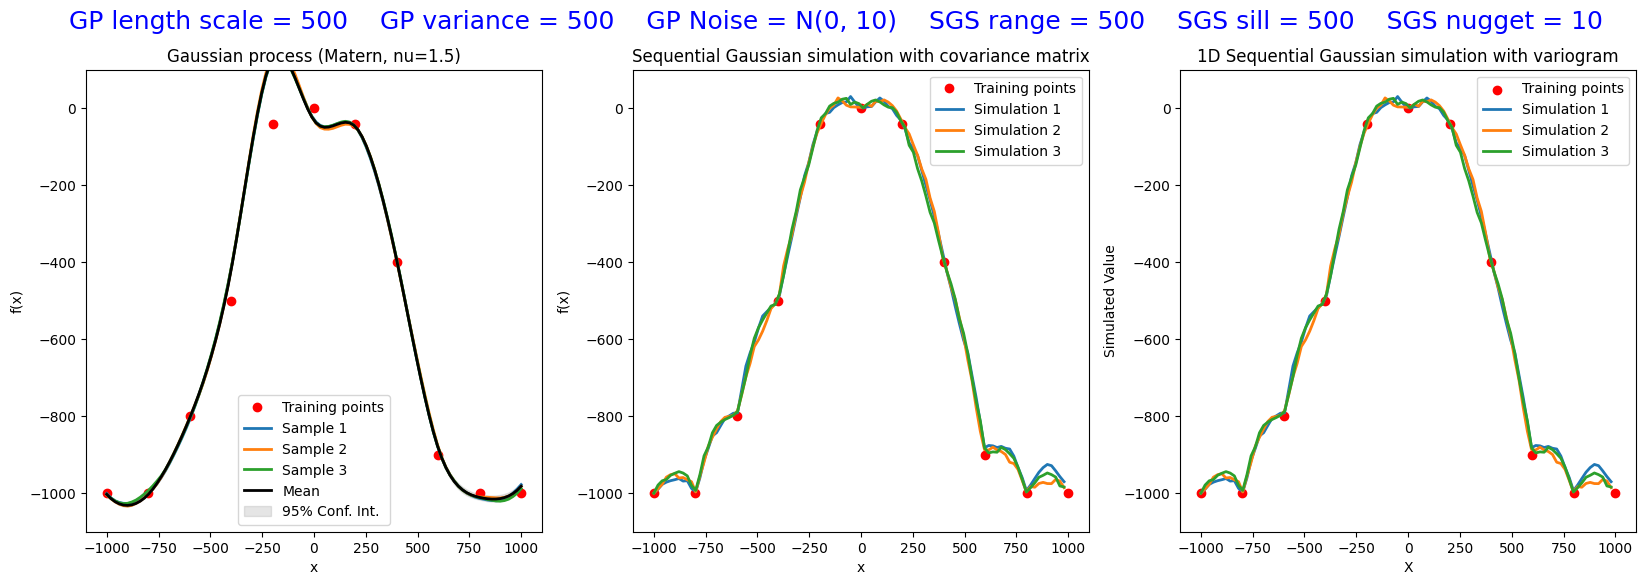

In [9]:
# PLOT GP AND SGSs COMPARISON

plt.figure(figsize=(20, 6))
plt.suptitle(f"GP length scale = {length_scale}    GP variance = {varaiance_for_title}    GP Noise = N(0, {noise})    SGS range = {range_a}    SGS sill = {sill}    SGS nugget = {noise}", fontsize=18, color="blue")

plt.subplot(1, 3, 1)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=2)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Conf. Int.')
plt.title('Gaussian process (Matern, nu=1.5)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('Sequential Gaussian simulation with covariance matrix')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train, y_train, c='red', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('1D Sequential Gaussian simulation with variogram')
plt.xlabel('X')
plt.ylabel('Simulated Value')
plt.legend()
#plt.grid(True)
plt.ylim((-1100, 100))

plt.show()


# Synthetic Seismic Data

In [10]:
# SciPy Ricker wavelet
from scipy.signal import ricker

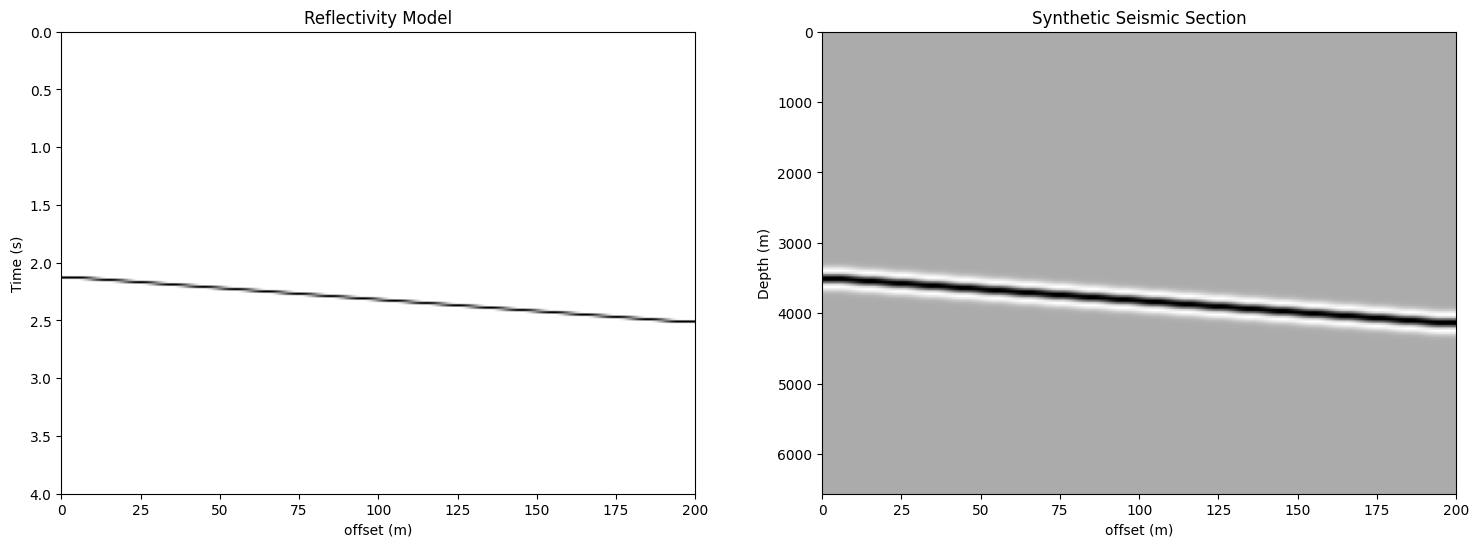

In [11]:
# Parameters
nt = 200    # Number of time samples
dt = 0.02   # Sampling interval (seconds)
nz = 20    # Number of traces
dx = 10     # Trace spacing (metres)

# Time and depth axis
time = np.arange(nt) * dt
offset = np.arange(nz) * dx

# Initialization of variable to save seismic sections (for serveral realizations)
n_realizations = 1
seismic_realizations=np.zeros((n_realizations, nt, nz))
seismic_realizations_depth=np.zeros((n_realizations, nt, nz))

# For loop for serveral realizations
for i in range(n_realizations):
    # Velocity model
    v = 1500 + np.random.normal(0, 150) # Velocity in m/s

    depth = time * v

    # Reflectivity model (2D grid with reflectors)
    reflectivity = np.zeros((nt, nz))

    ## Horizontal reflector
    #reflector_depth = int(2500 / (v * dt))
    #reflectivity[reflector_depth, :] = 0.7  # Reflectivity coefficient
#
    ## Horizontal reflector 2
    #reflector_depth_2 = int(1500 / (v * dt))
    #reflectivity[reflector_depth_2, :] = 0.5  # Reflectivity coefficient

    # Dipping reflector
    slope = 1
    intercept_depth = int(3500 / (v * dt))
    for ix in range(nz):
        depth_idx = intercept_depth + int(ix * slope)
        if depth_idx < nt:  # Ensure we don't go out of bounds
            reflectivity[depth_idx, ix] = 0.9  # Reflectivity coefficient

    ## Dipping reflector 2
    #slope_2 = 1
    #intercept_depth_2 = int(4500 / (v * dt))
    #for ix in range(nz):
    #    depth_idx = intercept_depth_2 + int(ix * slope)
    #    if depth_idx < nt:  # Ensure we don't go out of bounds
    #        reflectivity[depth_idx, ix] = 0.5  # Reflectivity coefficient

    # Ricker wavelet from SciPy
    f0 = 10  # Dominant frequency (Hz)
    wavelet = ricker(nt/10, f0 * dt * 10)

    # Convolution of wavelet with reflectivity model to get each trace
    #seismic = np.apply_along_axis(lambda trace: np.convolve(trace, wavelet, mode='same'), axis=0, arr=reflectivity)
    seismic_list = []
    seismic_list_depth = []
    for j in range(reflectivity.shape[1]):
        trace = reflectivity[:, j]
        convolved_trace = np.convolve(trace, wavelet, mode='same')
        # Trace depth conversion
        convolved_trace_depth = convolved_trace * v
        seismic_list.append(convolved_trace)
        seismic_list_depth.append(convolved_trace_depth)

    seismic = np.array(seismic_list).T
    seismic_depth = np.array(seismic_list_depth).T

    # Noise
    noise = 0.0 * np.random.randn(nt, nz)

    # Saving of each seismic section in an array
    seismic_realizations[i] = seismic + noise
    seismic_realizations_depth[i] = seismic + noise


# Plots
plt.figure(figsize=(18, 6))

# Plot of Reflectivity Model
plt.subplot(1, 2, 1)
plt.imshow(reflectivity, cmap='gray_r', aspect='auto', extent=[0, nz * dx, nt * dt, 0])
plt.title('Reflectivity Model')
plt.xlabel('offset (m)')
plt.ylabel('Time (s)')

# Plot of Seismic Section
plt.subplot(1, 2, 2)
plt.imshow(np.sum(seismic_realizations_depth, axis=0), cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.title('Synthetic Seismic Section')
plt.xlabel('offset (m)')
plt.ylabel('Depth (m)')
plt.show()

In [12]:
# Grid for further analysis

Xg, Yg = np.meshgrid(offset, depth)
grid_points = np.vstack([Xg.ravel(), Yg.ravel()]).T  # Flatten the grid to points

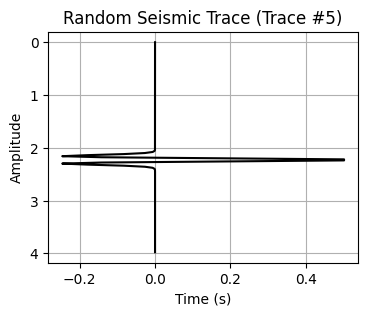

In [13]:
# Plot of a trace for QC

# Random trace index
random_trace_index = np.random.randint(0, nz)

# Selection of random trace
random_trace = seismic[:, random_trace_index]

# Plot of selected trace
plt.figure(figsize=(4, 3))
plt.plot(random_trace, time, color='black')
plt.gca().invert_yaxis()  # Invert y-axis to mimic seismic display
plt.title(f'Random Seismic Trace (Trace #{random_trace_index})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [14]:
# Decimation
trace_decimation_rate = 1  # One trace every decimation_rate traces
tr_i_for_cov = np.arange(0, nz, trace_decimation_rate)  # Trace indexes for covariance matrix

0.0002708108374773235
(4000, 4000)


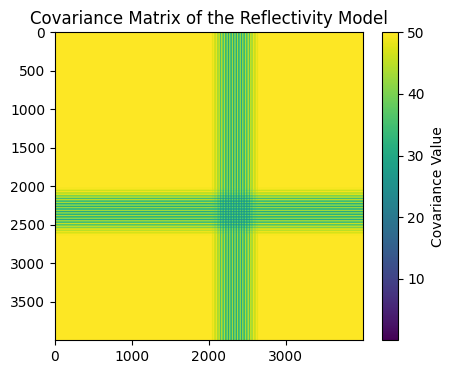

In [15]:
# Definition of points where covariance is computed
coords_list = []
for d in depth:
    for x in offset[tr_i_for_cov]:
        coords_list.append((d, x))
coords = np.array(coords_list)

# Hyperparameters for the kernels
length_scale = 300  # Length scale (adjust as needed)
variance = 50.0  # Variance (adjust as needed)
nu = 1.5 # 1/2 becomes exponential covariance function k(r) = exp(-r/l)
         # 3/2 and 5/2 for ML
         # Carl Edward Rasmussen and Christopher K. I. Williams,
         # Gaussian Processes for Machine Learning,
         # Adaptive Computation and Machine Learning (Cambridge, Mass: MIT Press, 2006), p85.

# Covariance matrix computation
mean = np.mean(seismic_depth[:,tr_i_for_cov].flatten())
centered_data = seismic_depth[:,tr_i_for_cov].flatten() - mean
cov_matrix_sgs = np.outer(centered_data, centered_data) / (len(seismic_depth[:,tr_i_for_cov].flatten()) - 1)

# Covariance matrix for the training points
#mean = np.mean(seismic_depth[:, tr_i_for_cov].flatten())
#n = len(seismic_depth[:, tr_i_for_cov].flatten())
#cov_matrix = np.zeros((n, n))
##print(cov_matrix.shape)
#for i in range (n):
#    for j in range (n):
#        cov_matrix[i, j] = (seismic_depth[:, tr_i_for_cov].flatten()[i] - mean)*(seismic_depth[:, tr_i_for_cov].flatten()[j]-mean) / (n-1)
#    print(f"Loop {i}")

# Covariance matrix for the training points
n = len(reflectivity[:,tr_i_for_cov]) * len(tr_i_for_cov)
cov_matrix_2 = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        #cov_matrix_2[i, j] = matern_kernel(seismic_depth[:, tr_i_for_cov].flatten()[i], seismic_depth[:, tr_i_for_cov].flatten()[j], length_scale, nu, variance)
        cov_matrix_2[i, j] = rbf_kernel(seismic_depth[:, tr_i_for_cov].flatten()[i], seismic_depth[:, tr_i_for_cov].flatten()[j], length_scale, variance)

print(mean)
print(cov_matrix_sgs.shape)

# Plot of covariance matrix
plt.figure(figsize=(5, 4))
plt.imshow(cov_matrix_2, cmap='viridis')
plt.colorbar(label='Covariance Value')
plt.title('Covariance Matrix of the Reflectivity Model')
#plt.clim(0, 0.0032)
plt.show()

C:\Users\cco\AppData\Local\Temp\ipykernel_38016\1305183390.py:61: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  simulated_values[i] = [simulated_value, variance]
C:\Users\cco\AppData\Local\Temp\ipykernel_38016\1305183390.py:60: RuntimeWarning: invalid value encountered in sqrt
  simulated_value = np.random.normal(mean, np.sqrt(variance))


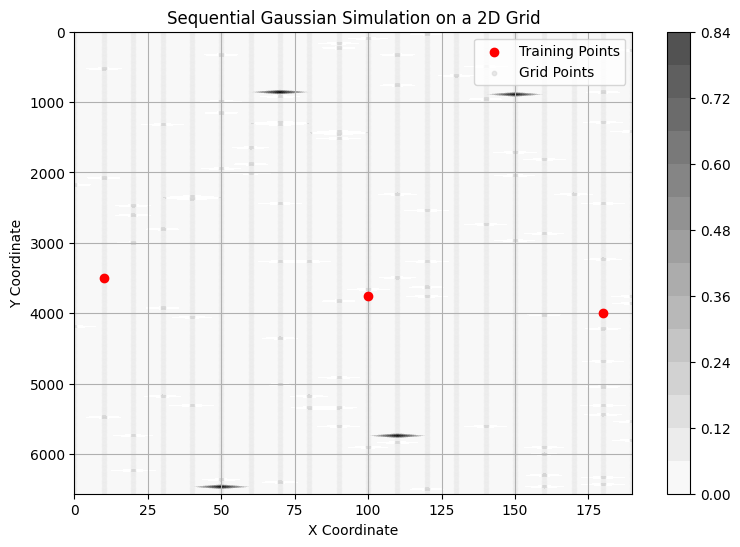

In [16]:
# SGS by reading entries of the computed covariance matrix
# instead of computing it for every step in the SGS

# Set the random seed for reproducibility
np.random.seed(42)

# Precomputed 4000x4000 covariance matrix (e.g., read from a file or generated previously)
# Ensure that cov_matrix is symmetric and positive definite
#cov_matrix = np.random.rand(4000, 4000)
cov_matrix_sgs = cov_matrix_2
cov_matrix_sgs = (cov_matrix_sgs + cov_matrix_sgs.T) / 2 + 5 * np.eye(4000)  # Symmetrize and ensure positive definiteness

# Define the known input data (coordinates) and observed values
obs_coords = np.array([[10, 3500], [100, 3750], [180, 4000]])  # 3 known points with x and z coordinates
obs_values = np.array([0.9, 0.9, 0.9])  # Observed values (1D scalars)

# Define a 2D grid of points (200 rows x 20 columns)
#x = np.linspace(0, 200, 20)  # X-axis values
#y = np.linspace(0, 5000, 200)  # Y-axis values
X_grid, Y_grid = np.meshgrid(offset[tr_i_for_cov], depth)
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T  # Flatten to a list of grid points

# Identify indexes of obs_coords in a flatten grid, to relate them then to the covariance matrix
temp_dist = np.zeros((len(grid_points)))
obs_idx = np.zeros((len(obs_coords)))
for j in range(len(obs_coords)):
    for k in range(len(grid_points)):
        temp_dist[k] = np.linalg.norm(grid_points[k] - obs_coords[j])
    obs_idx[j] = temp_dist.argmin()
obs_idx = obs_idx.astype(int).tolist()#.reshape((len(obs_idx), 1))

points_to_simulate = 100
# Choose 20 points randomly from the grid to simulate (can be any selection strategy)
simulated_indices = np.random.choice(range(len(grid_points)), points_to_simulate, replace=False)
simulated_points = grid_points[simulated_indices]

# Simulate values for the selected grid points sequentially
simulated_values = np.zeros((points_to_simulate,2))  # To store the simulated values

for i, point_idx in enumerate(simulated_indices):
    # Combine known and simulated points
    X_all = np.vstack([obs_coords, simulated_points[:i]])  # Current known set of coordinates
    X_all_idx = np.concatenate(([obs_idx, simulated_indices[:i+1]]))  # Current known set of coordinates

    # Extract submatrices from the covariance matrix
    #num_known = len(X_all)
    num_known = len(X_all_idx)
    #cov_11 = cov_matrix[:num_known, :num_known]  # Covariance among all known points
    cov_11 = cov_matrix_2[np.ix_(X_all_idx[:-1], X_all_idx[:-1])]
    #cov_12 = cov_matrix[:num_known, num_known:num_known + 1]  # Covariance between known and next simulated point
    cov_12 = cov_matrix_2[np.ix_(X_all_idx[:-1], [X_all_idx[num_known-1]])]
    #cov_22 = cov_matrix[num_known:num_known + 1, num_known:num_known + 1]  # Variance of the next simulated point
    cov_22 = cov_matrix_2[np.ix_([X_all_idx[num_known-1]], [X_all_idx[num_known-1]])]

    # Calculate mean and variance for the new simulated value
    mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([obs_values, simulated_values[:i,0]])
    variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12

    # Draw a random sample from the normal distribution
    simulated_value = np.random.normal(mean, np.sqrt(variance))
    simulated_values[i] = [simulated_value, variance]


grid_values = np.zeros((grid_points.shape[0],2))
grid_values[simulated_indices] = simulated_values
grid_values.shape

# Plotting the grid and the simulated points
plt.figure(figsize=(9, 6))
plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', label='Training Points', zorder=5)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='lightgrey', s=10, label='Grid Points', alpha=0.5)
#plt.scatter(simulated_points[:, 0], simulated_points[:, 1], cmap=simulated_values, label='Simulated Points', zorder=5)
plt.contourf(X_grid, Y_grid, grid_values[:,0].reshape((200, 20)), levels=14, cmap="gray_r", alpha=0.7)
plt.title('Sequential Gaussian Simulation on a 2D Grid')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\skgstat\Variogram.py:564: UserWarning: All input values are the same.
  warnings.warn('All input values are the same.')
d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\cco\AppData\Local\Temp\ipykernel_38016\3715238117.py:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  simulated_values[i] = [simulated_value, variance]


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


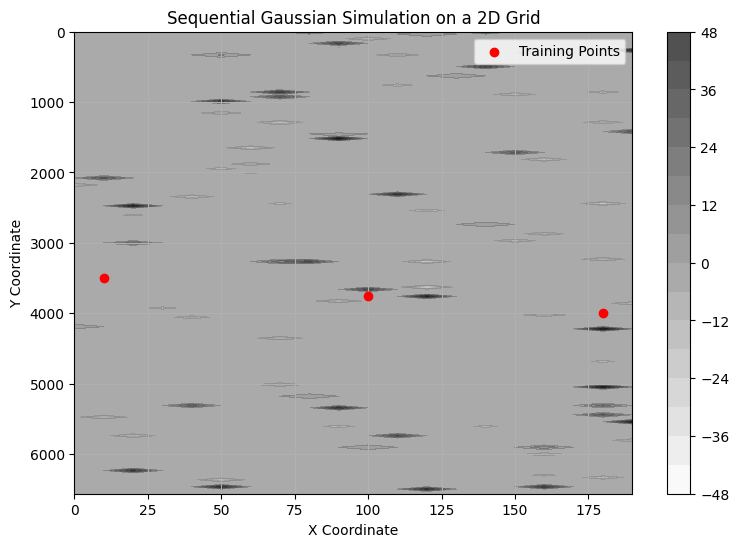

In [17]:
# SGS by giving variogram parameters
import skgstat as skg

# Simulate values for the selected grid points sequentially
simulated_points = np.zeros((points_to_simulate,2))  # To store the simulated values
simulated_values = np.zeros((points_to_simulate,2))  # To store the simulated values

for i, point_idx in enumerate(simulated_indices):
    # Combine known and simulated points
    X_all = np.vstack([obs_coords, simulated_points[:i]])  # Current known set of coordinates
    X_all_idx = np.concatenate(([obs_idx, simulated_indices[:i+1]]))  # Current known set of coordinates
    Y_all = np.hstack([obs_values, simulated_values[:i, 0]])  # Current known set of coordinates

    V = skg.Variogram(X_all, Y_all, fit_method='lm')
    range_opt = V.parameters[0]
    sill_opt = V.parameters[1]
    nugget_opt = V.parameters[2]


    cov_matrix_section = sill - variogram(h, range_a, sill, nugget)
        
    # Split the covariance matrix
    cov_11 = cov_matrix_section[:len(obs_coords)+i, :len(obs_coords)+i]
    cov_12 = cov_matrix_section[:len(obs_coords)+i, len(obs_coords)+i:len(obs_coords)+i+1]
    cov_22 = cov_matrix_section[len(obs_coords)+i:len(obs_coords)+i+1, len(obs_coords)+i:len(obs_coords)+i+1]

    # Calculate mean and variance for the new simulated value
    mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([obs_values, simulated_values[:i,0]])
    variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12

    # Draw a random sample from the normal distribution
    simulated_value = np.random.normal(mean, np.sqrt(variance))
    simulated_values[i] = [simulated_value, variance]


grid_values = np.zeros((grid_points.shape[0],2))
grid_values[simulated_indices] = simulated_values
grid_values.shape

# Plotting the grid and the simulated points
plt.figure(figsize=(9, 6))
plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', label='Training Points', zorder=5)
#plt.scatter(grid_points[:, 0], grid_points[:, 1], c='lightgrey', s=10, label='Grid Points', alpha=0.5)
#plt.scatter(simulated_points[:, 0], simulated_points[:, 1], cmap=simulated_values, label='Simulated Points', zorder=5)
plt.contourf(X_grid, Y_grid, grid_values[:,0].reshape((200, 20)), levels=14, cmap="gray_r", alpha=0.7)
plt.title('Sequential Gaussian Simulation on a 2D Grid')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


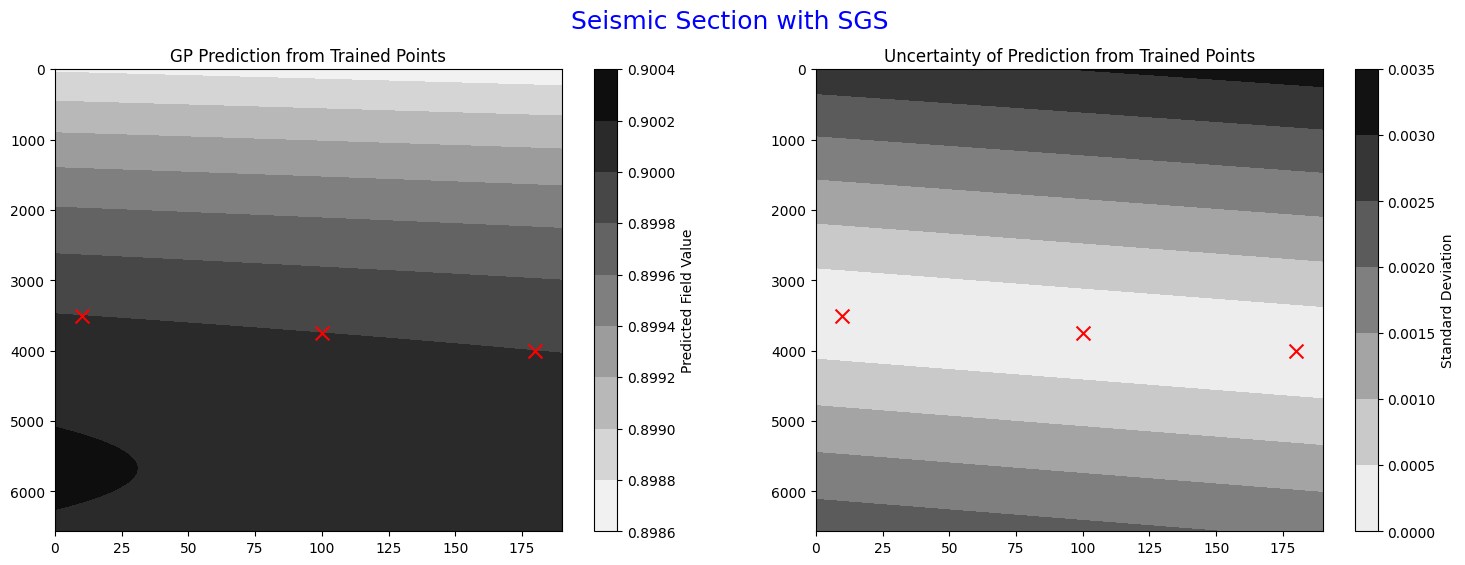

In [18]:
# Kernel
length_scale = 300.0
variance = 50.0
kernel = variance * RBF(length_scale=length_scale)

# Train a Gaussian process with the previous extracted points
gp_small = GaussianProcessRegressor(kernel=kernel, random_state=42)
gp_small.fit(obs_coords, obs_values)

# Predict the Gaussian field using the trained Gaussian process
Z_pred, Z_std = gp_small.predict(grid_points, return_std=True)
Z_pred = Z_pred.reshape(Xg.shape)


# Plot both original and reconstructed Gaussian fields

plt.figure(figsize=(18, 6))
plt.suptitle(f"Seismic Section with SGS", fontsize=18, color="blue")

# Predicted field
plt.subplot(1, 2, 1)
plt.contourf(Xg, Yg, Z_pred, cmap='gray_r')
plt.colorbar(label='Predicted Field Value')
plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.gca().invert_yaxis()
plt.title('GP Prediction from Trained Points')

# Standard deviation of predicted field
plt.subplot(1, 2, 2)
plt.contourf(Xg, Yg, Z_std.reshape(Xg.shape), cmap='gray_r')
plt.colorbar(label='Standard Deviation')
plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.gca().invert_yaxis()
plt.title('Uncertainty of Prediction from Trained Points')

plt.show()

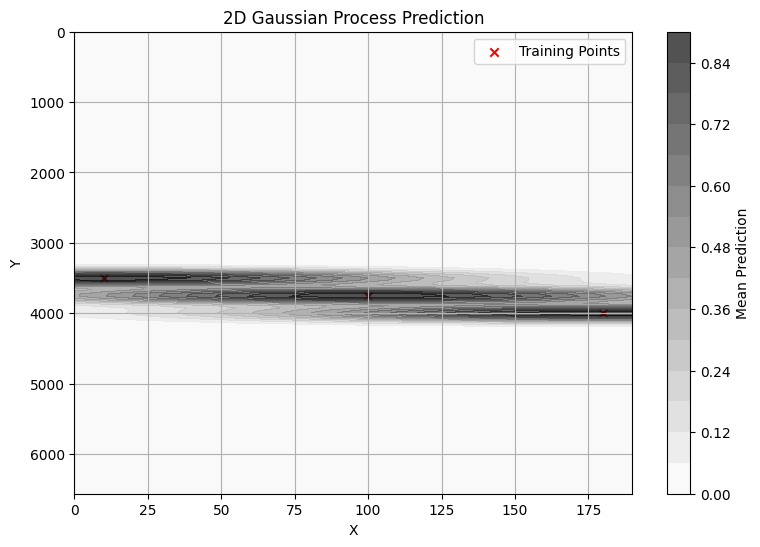

In [30]:
# GP Prediction

#samples = np.random.multivariate_normal(np.zeros((4000)), cov_matrix, 3)  # Draw 3 samples

# Hyperparameters
length_scale = 80.0  # Length scale of the kernel
nu = 1.5  # Smoothness parameter of the Matern kernel
variance = 50.0  # Variance (scale) of the kernel
noise = 0.1  # Noise level for observed data

# Covariance matrix for the training points
K = np.zeros((len(obs_coords), len(obs_coords)))
for i in range(len(obs_coords)):
    for j in range(len(obs_coords)):
        #K[i, j] = matern_kernel(obs_coords[i], obs_coords[j], length_scale, nu, variance)
        K[i, j] = rbf_kernel(obs_coords[i], obs_coords[j], length_scale, variance)

# Add noise to diagonal of the covariance matrix
K += noise * np.eye(len(obs_coords))

# Covariance matrix between training points and grid points
K_s = np.zeros((len(obs_coords), len(grid_points)))
for i in range(len(obs_coords)):
    for j in range(len(grid_points)):
        #K_s[i, j] = matern_kernel(obs_coords[i], grid_points[j], length_scale, nu, variance)
        K_s[i, j] = rbf_kernel(obs_coords[i], grid_points[j], length_scale, variance)

# Covariance matrix for the grid points
K_ss = np.zeros((len(grid_points), len(grid_points)))
for i in range(len(grid_points)):
    for j in range(len(grid_points)):
        #K_ss[i, j] = matern_kernel(grid_points[i], grid_points[j], length_scale, nu, variance)
        K_ss[i, j] = rbf_kernel(grid_points[i], grid_points[j], length_scale, variance)

# Mean and covariance of the conditional distribution
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(obs_coords)))  # Add a small term for numerical stability

# Mean of the conditioned Gaussian Process
mu_s = K_s.T.dot(K_inv).dot(obs_values)

# Covariance of the conditioned Gaussian Process
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Draw samples from the conditioned Gaussian Process
np.random.seed(42)
samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # Draw 3 samples

# Reshape the mean predictions for plotting
mu_s_grid = mu_s.reshape(Xg.shape)

# Plot the mean prediction
plt.figure(figsize=(9, 6))
plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', marker='x', label='Training Points')
plt.contourf(Xg, Yg, mu_s_grid, levels=14, cmap="gray_r", alpha=0.7)
plt.title('2D Gaussian Process Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.colorbar(label='Mean Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Covariance function of Statistics library

from statistics import covariance
covariance(reflectivity[:, tr_i_for_cov].flatten(), reflectivity[:, tr_i_for_cov].flatten())

0.004030757689422356

In [21]:
# Functions to fit a variogram model to the empirical variogram

def exponential_variogram(h, sill, range_, nugget):
    return nugget + sill * (1.0 - np.exp(-h / range_))

def spherical_variogram(h, sill, range_, nugget):
    return np.where(h <= range_, nugget + sill * (1.5 * (h / range_) - 0.5 * (h / range_)**3), nugget + sill)

def gaussian_variogram(h, sill, range_, nugget):
    return nugget + sill * (1 - np.exp(-(h**2) / (range_**2)))

# Define the loss function to minimize (Sum of Squared Errors)
def variogram_loss(params, h, gamma):
    sill, range_, nugget = params
    model_values = exponential_variogram(h, sill, range_, nugget)
    return np.sum((gamma - model_values) ** 2)  # Sum of squared errors

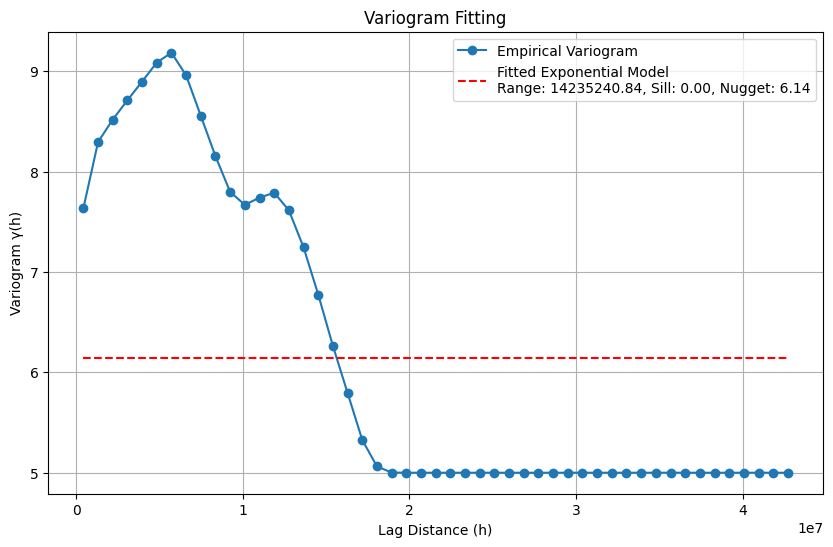

Optimal range of the variogram: 14235240.84
Optimal sill of the variogram: 0.00
Optimal nugget of the variogram: 6.14


In [22]:
# Computation of distance matrix between coordinates

dists = cdist(coords, coords, 'euclidean')**2
#dists = np.zeros((len(coords),1))
#for i in range (len(coords)):
#    for j in range (len(coords)):
#        dists[i] = np.sqrt(np.sum((coords[i] - coords[j])**2, axis=-1))

# Computation of empirical variogram or using covariance matrix from previous steps
#cov_matrix = np.exp(-dists / 10.0)
gamma = cov_matrix_sgs[0, 0] - cov_matrix_sgs

# Binning of offsets and computation of the average variogram for each bin
max_dist = np.max(dists)
bins = np.linspace(0, max_dist, 50)
bin_indices = np.digitize(dists, bins)

# Initialization of array for bin means
bin_means = []
bin_centers = []

for i in range(1, len(bins)):
    # Extraction of the gamma values corresponding to the current bin
    bin_gamma_values = gamma[bin_indices == i]
    if len(bin_gamma_values) > 0:
        bin_means.append(bin_gamma_values.mean())
        bin_centers.append((bins[i - 1] + bins[i]) / 2)

bin_means = np.array(bin_means)
bin_centers = np.array(bin_centers)

# Initialization of values for nugget, sill, and range
initial_sill = bin_means.max()
initial_range = np.max(bin_centers) / 3  # A third of the maximum distance to start
initial_nugget = bin_means.min()
#initial_nugget = 0
#initial_sill = 50#np.var(gamma)
#initial_range = 50


# Fitting of the variogram model

#popt, _ = curve_fit(gaussian_variogram, bin_centers, bin_means, p0=[initial_sill, initial_range, initial_nugget])
#sill_opt, range_opt, nugget_opt = popt

# Bounds for optimization: (lower bound, upper bound)
bounds = [(0, None), (0, None), (0, None)]  # Ensure non-negative values for sill, range, and nugget

# Minimization of the loss function with bounds
result = minimize(variogram_loss, [initial_sill, initial_range, initial_nugget], 
                  args=(bin_centers, bin_means), bounds=bounds)
sill_opt, range_opt, nugget_opt = result.x

# Computation of the fitted variogram model
fitted_variogram = gaussian_variogram(bin_centers, sill_opt, range_opt, nugget_opt)

# Plot of fitted variogram model with sill and nugget
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, bin_means, 'o-', label='Empirical Variogram')
#plt.plot(bin_centers, gaussian_variogram(bin_centers, sill_opt, range_opt, nugget_opt), 'r-', 
#         label=f'Fitted Exponential Model (Range={range_opt:.2f}, Sill={sill_opt:.2f}, Nugget={nugget_opt:.2f})')
plt.plot(bin_centers, fitted_variogram, 'r--', label=f'Fitted Exponential Model\nRange: {range_opt:.2f}, Sill: {sill_opt:.2f}, Nugget: {nugget_opt:.2f}')
plt.xlabel('Lag Distance (h)')
plt.ylabel('Variogram γ(h)')
plt.title('Variogram Fitting')
plt.legend()
plt.grid(True)
plt.show()

# Display of optimal range, sill, and nugget
print(f"Optimal range of the variogram: {range_opt:.2f}")
print(f"Optimal sill of the variogram: {sill_opt:.2f}")
print(f"Optimal nugget of the variogram: {nugget_opt:.2f}")

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


414.1078247182151

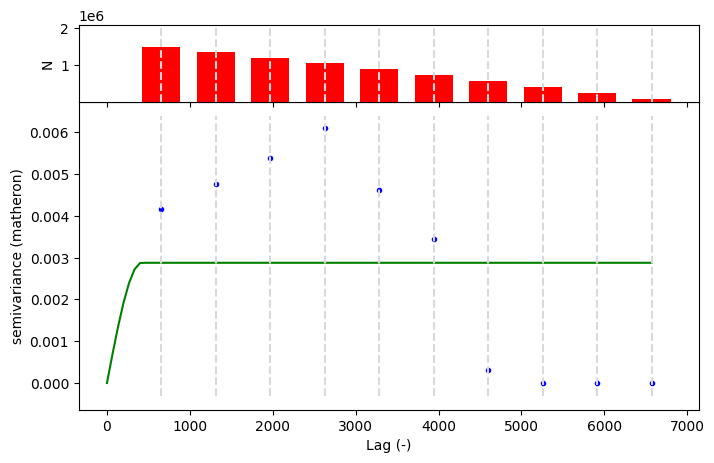

In [23]:
# QC with skgstat (SciKit gstat)
import skgstat as skg

values = reflectivity.flatten()

#V = skg.Variogram(coords[0::10], values[0::10])
V = skg.Variogram(coords, values)
V.plot()
V.parameters[0]

In [24]:
range_opt = V.parameters[0]
sill_opt = V.parameters[1]
nugget_opt = V.parameters[2]

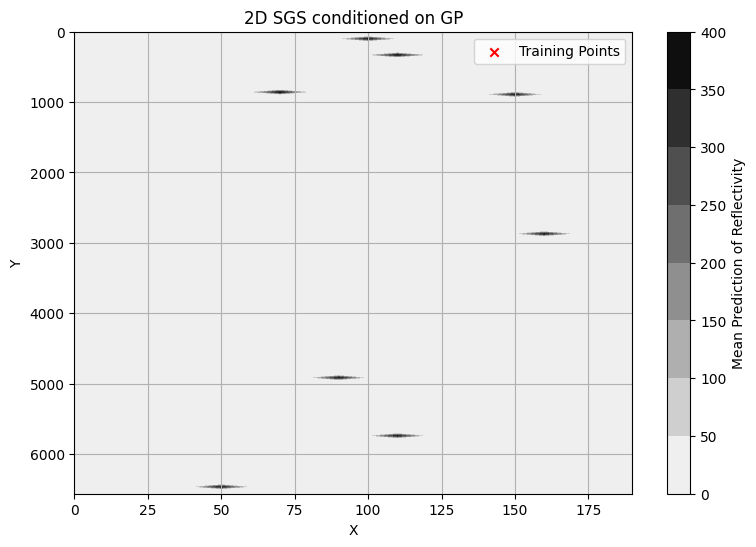

In [25]:
# GP x SGS Plot

mult = np.multiply(grid_values[:,1].reshape((200, 20)), Z_pred)

# Plot the mean prediction
plt.figure(figsize=(9, 6))
plt.scatter(obs_coords[:, 0], obs_coords[:, 1], c='red', marker='x', label='Training Points')
#plt.tricontourf(mult[:, 0], mult[:, 1])

#plt.tricontourf(X_grid.flatten(), Y_grid.flatten(), mult, cmap="gray_r", alpha=0.6)

plt.contourf(Xg, Yg, mult, cmap="gray_r")
plt.title('2D SGS conditioned on GP')
plt.ylim(0, np.max(depth))
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Mean Prediction of Reflectivity')
plt.legend()
plt.grid(True)
plt.show()